### Libs import

#### Primary libs

In [1]:
from tqdm.notebook import tqdm

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

import warnings
warnings.filterwarnings("ignore")

#### ML modules

Torch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim.lr_scheduler import StepLR

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Not Torch

In [4]:
import gc

from scipy.signal import correlate
from statsmodels.graphics.tsaplots import plot_acf
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Custom modules

In [5]:
from modules.loss_functions import SharpeLoss, MeanReturnLoss
from modules.networks import LSTMModel, LSTMWithAttention, LSTMWithAttentionAlt, ConvLSTMWithAttention

### Functions definings

### Dataloading

In [6]:
PATH = 'data/binance/fut/hour'

close = pd.read_csv(f'{PATH}/close.csv', index_col='openTime')
open = pd.read_csv(f'{PATH}/open.csv', index_col='openTime')
high = pd.read_csv(f'{PATH}/high.csv', index_col='openTime')
low = pd.read_csv(f'{PATH}/low.csv', index_col='openTime')
qvolume = pd.read_csv(f'{PATH}/qvolume.csv', index_col='openTime')
bvolume = pd.read_csv(f'{PATH}/bvolume.csv', index_col='openTime')
ntrades = pd.read_csv(f'{PATH}/ntrades.csv', index_col='openTime')
takerbuybvolume = pd.read_csv(f'{PATH}/takerbuybvolume.csv', index_col='openTime')
takerbuyqvolume = pd.read_csv(f'{PATH}/takerbuyqvolume.csv', index_col='openTime')

In [7]:
good_tickers = close.isna().sum()[close.isna().sum() < 10_000].index

close = close[good_tickers]
close.index = pd.to_datetime(close.index)
close = close.resample('4H').first()

open = open[good_tickers]
open.index = pd.to_datetime(open.index)
open = open.resample('4H').first()

high = high[good_tickers]
high.index = pd.to_datetime(high.index)
high = high.resample('4H').first()

low = low[good_tickers]
low.index = pd.to_datetime(low.index)
low = low.resample('4H').first()

bvolume = bvolume[good_tickers]
bvolume.index = pd.to_datetime(bvolume.index)
bvolume = bvolume.resample('4H').first()

qvolume = qvolume[good_tickers]
qvolume.index = pd.to_datetime(qvolume.index)
qvolume = qvolume.resample('4H').first()

ntrades = ntrades[good_tickers]
ntrades.index = pd.to_datetime(ntrades.index)
ntrades = ntrades.resample('4H').first()

takerbuybvolume = takerbuybvolume[good_tickers]
takerbuybvolume.index = pd.to_datetime(takerbuybvolume.index)
takerbuybvolume = takerbuybvolume.resample('4H').first()

takerbuyqvolume = takerbuyqvolume[good_tickers]
takerbuyqvolume.index = pd.to_datetime(takerbuyqvolume.index)
takerbuyqvolume = takerbuyqvolume.resample('4H').first()



returns = close.pct_change().shift(-1).dropna()
ret_col = np.array(returns.columns) + '_ret'
returns.columns = ret_col

close_col = np.array(close.columns) + '_close'
close.columns = close_col

open_col = np.array(open.columns) + '_open'
open.columns = open_col

high_col = np.array(high.columns) + '_high'
high.columns = high_col

low_col = np.array(low.columns) + '_low'
low.columns = low_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

qvolume_col = np.array(qvolume.columns) + '_qvolume'
qvolume.columns = qvolume_col

bvolume_col = np.array(bvolume.columns) + '_bvolume'
bvolume.columns = bvolume_col

ntrades_col = np.array(ntrades.columns) + '_ntrades'
ntrades.columns = ntrades_col

takerbuybvolume_col = np.array(takerbuybvolume.columns) + '_takerbuybvolume'
takerbuybvolume.columns = takerbuybvolume_col

takerbuyqvolume_col = np.array(takerbuyqvolume.columns) + '_takerbuyqvolume'
takerbuyqvolume.columns = takerbuyqvolume_col


train_columns = np.array([close_col, open_col, high_col, low_col, bvolume_col, qvolume_col, ntrades_col, takerbuybvolume_col, takerbuyqvolume_col])
train_columns = train_columns.reshape(train_columns.shape[0] * train_columns.shape[1],)


full_data = pd.concat([
  close.pct_change(), open.pct_change(), high.pct_change(), low.pct_change(), bvolume.pct_change(),
  qvolume.pct_change(), ntrades.pct_change(), takerbuybvolume.pct_change(), takerbuyqvolume.pct_change(), returns
], axis=1).dropna()
full_data.index = pd.to_datetime(full_data.index)

training_data = full_data[train_columns]



window_size = 100

all_x = np.lib.stride_tricks.sliding_window_view(training_data.values, (window_size, training_data.shape[1]))[:, 0]
all_y = full_data[ret_col].iloc[99:].values

In [8]:
# Формируем обучающую выборку
x_test = all_x[-850:].view()  # Все, кроме последних 1000
y_test = all_y[-850:].view()  # Все, кроме последних 1000

x = all_x[:-(850 + 120)].view()
y = all_y[:-(850 + 120)].view()

# Определяем длину валидационной выборки
val_len = 1000

# Определяем индексы для валидационной выборки
val_start = x.shape[0] // 2 - val_len // 2
val_end = val_start + val_len

# Формируем валидационную выборку
x_val = x[val_start:val_end]
y_val = y[val_start:val_end]

# Определяем отступы для тестовой выборки
offset = 110

# Индексы для тестовой выборки
test_start = max(0, val_start - offset)
test_end = min(x.shape[0], val_end + offset)

# Формируем тренировочную выборку
x_train = np.concatenate((x[:test_start], x[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

# Проверяем размеры выборок
print(f"train_x shape: {x_train.shape}")
print(f"train_y shape: {y_train.shape}")
print(f"val_x shape: {x_val.shape}")
print(f"val_y shape: {y_val.shape}")
print(f"test_x shape: {x_test.shape}")
print(f"test_y shape: {y_test.shape}")

train_x shape: (5262, 100, 567)
train_y shape: (5262, 63)
val_x shape: (1000, 100, 567)
val_y shape: (1000, 63)
test_x shape: (850, 100, 567)
test_y shape: (850, 63)


In [9]:
x_train = torch.Tensor(x_train)
x_train = np.where(np.isinf(x_train), np.nan, x_train)
x_train = np.where(np.isnan(x_train), np.nanmean(x_train, axis=0), x_train)
x_train = torch.Tensor(x_train)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = np.where(np.isinf(y_train), np.nan, y_train)
y_train = np.where(np.isnan(y_train), np.nanmean(y_train, axis=0), y_train)
y_train = torch.Tensor(y_train)


x_val = torch.Tensor(x_val)
x_val = np.where(np.isinf(x_val), np.nan, x_val)
x_val = np.where(np.isnan(x_val), np.nanmean(x_val, axis=0), x_val)
x_val = torch.Tensor(x_val)

y_val = torch.tensor(y_val, dtype=torch.float32)
y_val = np.where(np.isinf(y_val), np.nan, y_val)
y_val = np.where(np.isnan(y_val), np.nanmean(y_val, axis=0), y_val)
y_val = torch.Tensor(y_val)

x_test = torch.Tensor(x_test)
x_test = np.where(np.isinf(x_test), np.nan, x_test)
x_test = np.where(np.isnan(x_test), np.nanmean(x_test, axis=0), x_test)
x_test = torch.Tensor(x_test)

y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = np.where(np.isinf(y_test), np.nan, y_test)
y_test = np.where(np.isnan(y_test), np.nanmean(y_test, axis=0), y_test)
y_test = torch.tensor(y_test, dtype=torch.float32)

print("Shape of x_train:", x_train.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_train.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_val.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

print("Shape of x_train:", x_test.shape)  # Ожидаемая форма: (3107, 50, 465)
print("Shape of y_train:", y_test.shape)  # Ожидаемая форма: (3107,)

Shape of x_train: torch.Size([5262, 100, 567])
Shape of y_train: torch.Size([5262, 63])
Shape of x_train: torch.Size([1000, 100, 567])
Shape of y_train: torch.Size([850, 63])
Shape of x_train: torch.Size([850, 100, 567])
Shape of y_train: torch.Size([850, 63])


### ML

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Создаем dataset и dataloader
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

batch_size = 630  # Выбираем подходящий размер батча

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
share_values = []
weights_penalties = []
turnover_penalties = []

In [18]:
sharpe_loss = SharpeLoss()
returns_loss = MeanReturnLoss(turnover_penalty_weight=10)

In [56]:
PARAMS_DICT = {
    'input_size': x_train.shape[2],
    'hidden_size': 24,
    'hidden_size2': 24,
    'output_size':  y_train.shape[1],
    'learning_rate': 0.0001,
    'dropout1': 0.6,
    'dropout2': 0.6,
    'num_epochs': 100,
    'num_heads': 4,
    'conv_out_channels': 64,
    'conv_kernel_size': 3,
    'PRINT_PARAM': 1,
    'device': device,
    'batch_size': batch_size,
    'alpha': sharpe_loss.alpha,
    'epsilon': sharpe_loss.epsilon,
    'weight_penalty_factor': sharpe_loss.weight_penalty_factor,
    'optimizer': 'Adam',
    'weight_decay': 1e-2,
}

pred_dict = {}
pred_dict['train'] = []
pred_dict['val'] = []
pred_dict['test'] = []

# Гиперпараметры
input_size = PARAMS_DICT['input_size']  # Количество факторов (465)
hidden_size = PARAMS_DICT['hidden_size']  # Размер скрытого слоя
hidden_size2 = PARAMS_DICT['hidden_size2'] #
output_size = PARAMS_DICT['output_size']   # Одно выходное значение
learning_rate = PARAMS_DICT['learning_rate']
num_epochs = PARAMS_DICT['num_epochs']
PRINT_PARAM = PARAMS_DICT['PRINT_PARAM']

# Инициализация модели, потерь и оптимизатора
model = ConvLSTMWithAttention(
    input_size,
    hidden_size,
    hidden_size2,
    output_size,
    dropout=PARAMS_DICT['dropout1'],
    dropout2=PARAMS_DICT['dropout2'],
    num_heads=PARAMS_DICT['num_heads'],
    conv_out_channels=PARAMS_DICT['conv_out_channels']
).to(device)
criterion = sharpe_loss.to(device)
optimizer = optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

# Листы для хранения значений потерь
train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход (forward pass)
        outputs = model(batch_x)
        
        # Вычисление потерь
        loss = criterion(outputs.squeeze(), batch_y.float())
        
        # Обратный проход (backward pass) для вычисления градиентов
        loss.backward()
        
        # Ограничение градиентов
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Обновление весов
        optimizer.step()
        
        # Агрегация потерь за эпоху
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    
    # Валидация модели
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_outputs = model(val_x)
            val_loss += criterion(val_outputs.squeeze(), val_y.float()).item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Обновление learning rate через scheduler
    scheduler.step()

    # Печать результатов
    if epoch % PRINT_PARAM == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.10f}, Validation Loss: {val_loss:.10f}')

# Визуализация потерь
plt.figure(figsize=(10, 5))
plt.plot(range(PRINT_PARAM, len(train_losses) + 1, PRINT_PARAM), train_losses, label='Train Loss')
plt.scatter(range(PRINT_PARAM, len(val_losses) + 1, PRINT_PARAM), val_losses, label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [0/100], Loss: 0.0006528980, Validation Loss: 1343902696.0000000000
Epoch [1/100], Loss: -0.0018302646, Validation Loss: 1449510408.0000000000
Epoch [2/100], Loss: -0.0024286949, Validation Loss: 1460459040.0000000000
Epoch [3/100], Loss: -0.0046289929, Validation Loss: 1271770168.0000000000
Epoch [4/100], Loss: -0.0028755871, Validation Loss: 1024173472.0000000000
Epoch [5/100], Loss: -0.0054058823, Validation Loss: 832834700.0000000000
Epoch [6/100], Loss: -0.0028889886, Validation Loss: 496357548.0000000000
Epoch [7/100], Loss: -0.0022880048, Validation Loss: 342703654.0000000000
Epoch [8/100], Loss: -0.0046860845, Validation Loss: 216628438.0000000000
Epoch [9/100], Loss: -0.0022492352, Validation Loss: 204267516.0000000000
Epoch [10/100], Loss: -0.0031426839, Validation Loss: 134093643.0000000000
Epoch [11/100], Loss: -0.0048014791, Validation Loss: 92546804.0000000000
Epoch [12/100], Loss: -0.0053877072, Validation Loss: 78592347.0000000000
Epoch [13/100], Loss: -0.00379475

KeyboardInterrupt: 

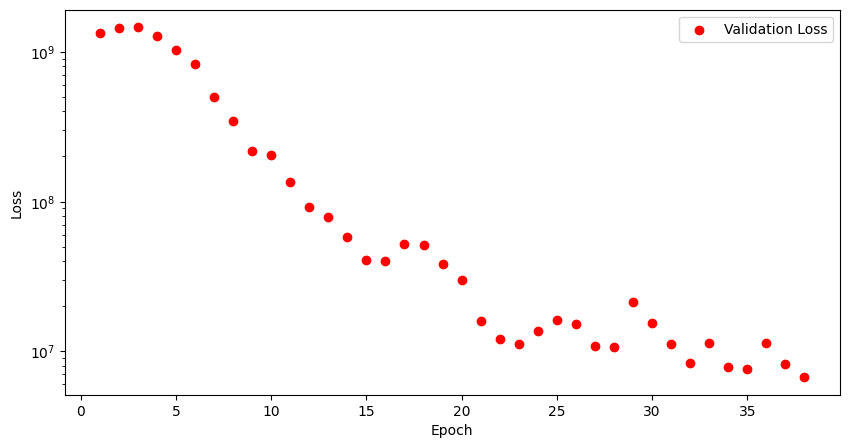

In [57]:
plt.figure(figsize=(10, 5))
# plt.plot(range(PRINT_PARAM, len(val_losses) + 1, PRINT_PARAM), np.array(train_losses), label='Train Loss')
plt.scatter(range(PRINT_PARAM, len(val_losses) + 1, PRINT_PARAM), np.array(val_losses), label='Validation Loss', color='r')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sharpe_train:  16.90844
Sharpe_val:  16.792624
Sharpe_test:  26.943354


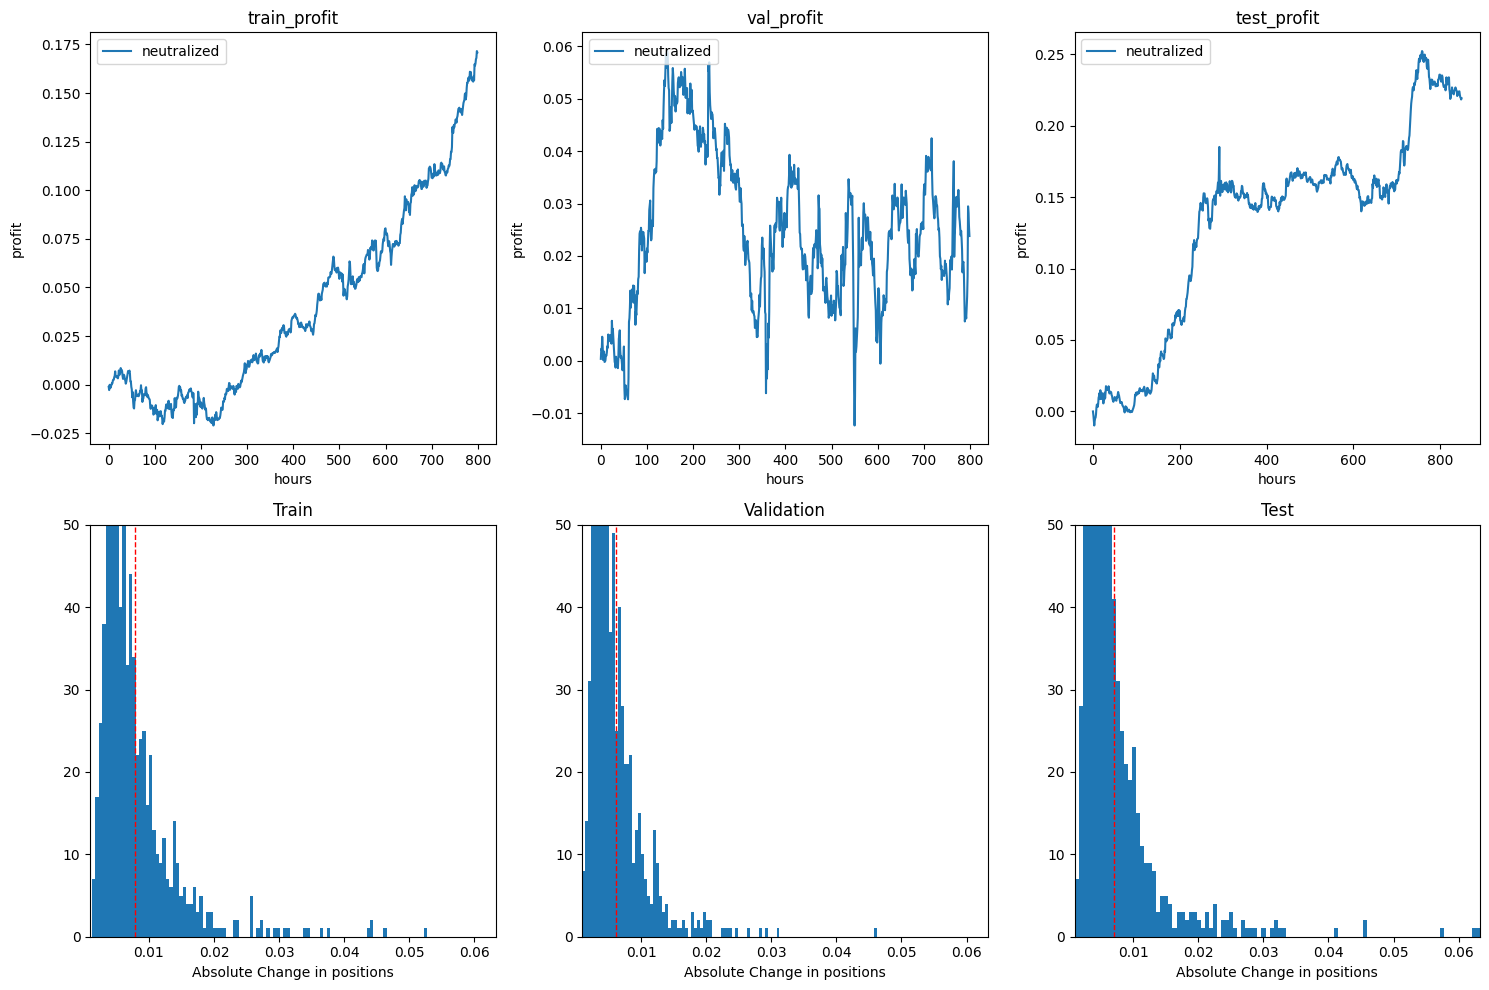

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

model.eval()
with torch.no_grad():
    train_predictions = model(x_train[-800:].to(device)).detach().cpu().numpy()

pred_dict['train'].append(train_predictions)

pred_df = pd.DataFrame(train_predictions, columns=close.columns)
alpha1 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha1 = alpha1.div(alpha1.abs().sum(axis=1), axis=0)
axes[0, 0].plot(
    (alpha1.iloc[-len(x_test):] * pd.DataFrame(y_train[-800:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='neutralized'
)
# axes[0, 0].set_ylim(-0.05, 0.5)
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_title('train_profit')
axes[0, 0].set_xlabel('hours')
axes[0, 0].set_ylabel('profit')

with torch.no_grad():
    val_predictions = model(x_val[-800:].to(device)).detach().cpu().numpy()

pred_dict['val'].append(val_predictions)

pred_df = pd.DataFrame(val_predictions, columns=close.columns)
alpha2 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha2 = alpha2.div(alpha2.abs().sum(axis=1), axis=0)
axes[0, 1].plot(
    (alpha2.iloc[-len(x_test):] * pd.DataFrame(y_val[-800:].detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum(),
    label='neutralized'
)
# axes[0, 1].set_ylim(-0.05, 0.5)
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_title('val_profit')
axes[0, 1].set_xlabel('hours')
axes[0, 1].set_ylabel('profit')

with torch.no_grad():
    test_predictions = model(x_test.to(device)).detach().cpu().numpy()

pred_dict['test'].append(test_predictions)

pred_df = pd.DataFrame(test_predictions, columns=close.columns)
alpha3 = pred_df.subtract(pred_df.mean(axis=1), axis=0)
alpha3 = alpha3.div(alpha3.abs().sum(axis=1), axis=0)
axes[0, 2].plot(
    (alpha3.iloc[-len(x_test):] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum(),
    label='neutralized'
)
axes[0, 2].legend(loc='upper left')
axes[0, 2].set_title('test_profit')
axes[0, 2].set_xlabel('hours')
axes[0, 2].set_ylabel('profit')

min_value = min(
    (alpha1.iloc[-len(x_test):] * pd.DataFrame(y_train.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
    (alpha2.iloc[-len(x_test):] * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
    (alpha3.iloc[-len(x_test):] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().min(),
)
max_value = max(
    (alpha1.iloc[-len(x_test):] * pd.DataFrame(y_train.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max(),
    (alpha2.iloc[-len(x_test):] * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max(),
    (alpha3.iloc[-len(x_test):] * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).cumsum().max()
)

# axes[0, 0].set_ylim(min_value, max_value)
# axes[0, 1].set_ylim(min_value, max_value)
# axes[0, 2].set_ylim(min_value, max_value)

# Рассчитаем минимальные и максимальные значения для оси x
x_min = min(
            alpha1.diff().abs().dropna().sum(axis=1).min(),
            alpha2.diff().abs().dropna().sum(axis=1).min(),
            alpha3.diff().abs().dropna().sum(axis=1).min())

x_max = max(
            alpha1.diff().abs().dropna().sum(axis=1).max(),
            alpha2.diff().abs().dropna().sum(axis=1).max(),
            alpha3.diff().abs().dropna().sum(axis=1).max())

# Построение гистограмм
axes[1, 0].hist(alpha1.diff().abs().dropna().sum(axis=1), bins=100)
axes[1, 1].hist(alpha2.diff().abs().dropna().sum(axis=1), bins=100)
axes[1, 2].hist(alpha3.diff().abs().dropna().sum(axis=1), bins=100)

axes[1, 0].set_ylim(0, 50)
axes[1, 1].set_ylim(0, 50)
axes[1, 2].set_ylim(0, 50)

# Установим одинаковые пределы по оси x для всех графиков
for ax in axes[1, :]:
    ax.set_xlim([x_min, x_max])

# Рассчитаем среднее для каждого графика
mean_alpha1 = (alpha1.diff().abs().dropna().sum(axis=1)).mean()
mean_alpha2 = (alpha2.diff().abs().dropna().sum(axis=1)).mean()
mean_alpha3 = (alpha3.diff().abs().dropna().sum(axis=1)).mean()

# Добавление вертикальных линий среднего
axes[1, 0].axvline(mean_alpha1, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha1:.2f}')
axes[1, 1].axvline(mean_alpha2, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha2:.2f}')
axes[1, 2].axvline(mean_alpha3, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_alpha3:.2f}')

# Заголовки подграфиков
axes[1, 0].set_title('Train')
axes[1, 0].set_xlabel('Absolute Change in positions')

axes[1, 1].set_title('Validation')
axes[1, 1].set_xlabel('Absolute Change in positions')

axes[1, 2].set_title('Test')
axes[1, 2].set_xlabel('Absolute Change in positions')

print(
    'Sharpe_train: ', (alpha1 * pd.DataFrame(y_train.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).sum() / \
    (alpha1 * pd.DataFrame(y_train.detach().numpy(), columns=close.columns)).dropna().abs().sum(axis=1).std()
)
print(
    'Sharpe_val: ', (alpha1 * pd.DataFrame(y_train.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).sum() / \
    (alpha2 * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).dropna().abs().sum(axis=1).std(),
)
print(
    'Sharpe_test: ', (alpha1 * pd.DataFrame(y_train.detach().numpy(), columns=close.columns)).dropna().sum(axis=1).sum() / \
    (alpha3 * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).dropna().abs().sum(axis=1).std(),
)

plt.tight_layout()
plt.show()

In [60]:
alpha1.diff().abs().sum(axis=1).mean() * 6

0.04705067351460457

### hyperparams optimization

In [17]:
# Функция обучения модели
def train_model(params, train_loader, val_loader, device):
    model = ConvLSTMWithAttention(
        input_size=params['input_size'],
        hidden_size=params['hidden_size'],
        hidden_size2=params['hidden_size2'],
        output_size=params['output_size'],
        dropout=params['dropout1'],
        dropout2=params['dropout2'],
        num_heads=params['num_heads'],
        conv_out_channels=params['conv_out_channels']
    ).to(device)

    criterion = sharpe_loss.to(device)
    optimizer = optim.NAdam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

    train_losses = []
    val_losses = []

    for epoch in range(params['num_epochs']):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.float())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(device), val_y.to(device)
                val_outputs = model(val_x)
                val_loss += criterion(val_outputs.squeeze(), val_y.float()).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        scheduler.step()

    return val_losses[-1]  # Возвращаем последнее значение валидационной потери

# Функция-цель для оптимизации гиперпараметров
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    hidden_size = trial.suggest_int('hidden_size', 8, 16)  # Примерный диапазон
    hidden_size2 = hidden_size  # Можно сделать одинаковым
    num_heads = 4  # Фиксированное значение, которое делит на hidden_size
    input_size = x_train.shape[2]  # Предполагаем, что x_train доступен
    output_size = y_train.shape[1]  # Предполагаем, что y_train доступен

    params = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'hidden_size2': hidden_size2,
        'output_size': output_size,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
        'dropout1': trial.suggest_float('dropout1', 0.3, 0.6),
        'dropout2': trial.suggest_float('dropout2', 0.3, 0.6),
        'num_epochs': 100,  # Можно изменить
        'num_heads': num_heads,
        'conv_out_channels': 64,  # Фиксированное значение или изменить
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-5, 1e-2),
        'PRINT_PARAM': 1,
        'device': device,
        'batch_size': batch_size,
        'alpha': sharpe_loss.alpha,
        'epsilon': sharpe_loss.epsilon,
        'weight_penalty_factor': sharpe_loss.weight_penalty_factor,
        'optimizer': 'Adam',
    }

    val_loss = train_model(params, train_loader, val_loader, params['device'])
    return val_loss

# Создание и запуск исследования Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)

# Визуализация результатов
optuna.visualization.plot_optimization_history(study)

[I 2024-10-14 13:23:54,621] A new study created in memory with name: no-name-51584f0b-f655-4ff8-8e57-64200fea1f1f
[W 2024-10-14 13:24:10,603] Trial 0 failed with parameters: {'hidden_size': 12, 'learning_rate': 3.44961430084804e-05, 'dropout1': 0.4067529259883763, 'dropout2': 0.5718331651162792, 'weight_decay': 0.0021422361932376464} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\python\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ciell\AppData\Local\Temp\ipykernel_3924\1406031045.py", line 83, in objective
    val_loss = train_model(params, train_loader, val_loader, params['device'])
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ciell\AppData\Local\Temp\ipykernel_3924\1406031045.py", line 24, in train_model
    for batch_x, batch_y in train_loader:
  File "c:\python\Lib\site-p

KeyboardInterrupt: 

In [29]:
alpha2.diff().abs().sum(axis=1).mean() * 6

0.1092759445309639

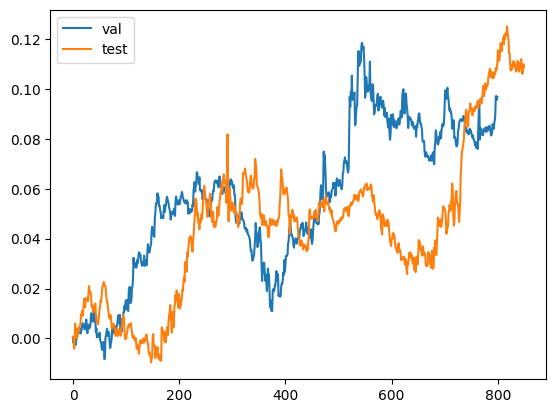

In [45]:
plt.plot(
    (alpha2.ffill() * pd.DataFrame(y_val[-800:].detach().numpy(), columns=close.columns)).sum(axis=1).cumsum().values,
    label='val'
)

plt.plot(
    (alpha3.ffill() * pd.DataFrame(y_test.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum().values,
    label='test'
)

plt.legend()
plt.show()

# (alpha2.ffill() * pd.DataFrame(y_val.detach().numpy(), columns=close.columns)).sum(axis=1).cumsum().iloc[-1]
# alpha2.ffill()

In [66]:
alpha1.isna().sum().mean(), alpha2.isna().sum().mean(), alpha3.isna().sum().mean()

(0.0, 0.0, 0.0)

### Idea

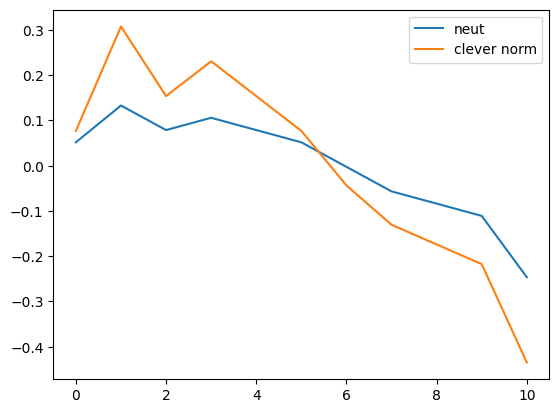

In [67]:
a = np.array([1, 4, 2, 3, 2, 1, -1, -3, -4, -5, -10])

b = a - a.mean()
b = b / np.abs(b).sum()

c = np.concatenate((a[a > 0] / a[a > 0].sum(), a[a < 0] / np.abs(a[a < 0]).sum()))

plt.plot(b, label='neut')
plt.plot(c, label='clever norm')
plt.legend()

In [68]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[-6.4552e-05, -7.7805e-04, -9.3563e-04],
                       [-9.4042e-04, -2.3428e-04, -5.3657e-04],
                       [-6.1739e-04, -8.1444e-04, -1.1020e-03],
                       ...,
                       [ 1.6850e-03, -1.0100e-02,  6.0756e-03],
                       [-4.3722e-03, -1.3558e-02, -1.3563e-02],
                       [-1.6005e-02, -9.5400e-03,  6.5016e-03]],
              
                      [[ 2.5901e-03,  5.5035e-03, -1.7381e-03],
                       [ 1.8424e-03,  9.6347e-04, -2.4492e-03],
                       [-2.2790e-04,  9.4178e-04, -1.6623e-03],
                       ...,
                       [ 1.0796e-02, -1.3988e-02,  5.1294e-03],
                       [ 5.8604e-03, -6.2753e-03,  1.2308e-02],
                       [-3.1313e-03,  1.5282e-02,  1.7676e-02]],
              
                      [[-7.9266e-04, -3.4475e-03, -8.9696e-04],
                       [ 3.3956e-04, -2.0500e-03, 

In [69]:
# Подсчет параметров
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество обучаемых параметров: {num_params}")

Количество обучаемых параметров: 199925


In [42]:
torch.save(model, 'models/binance/4hours/model5.pth')

In [482]:
torch.save(model.state_dict(), "models/binance/hour/sixth.pth")

In [224]:
share_values_np = np.array([tensor.cpu().detach().numpy() for tensor in share_values])
weights_penalties_np = np.array([tensor.cpu().detach().numpy() for tensor in weights_penalties])
turnover_penalties_np = np.array([tensor.cpu().detach().numpy() for tensor in turnover_penalties])
# weights_penalties
# turnover_penalties

In [225]:
metrics = pd.DataFrame({
  'sharpe_values': share_values_np,
  # 'weights_penalties': weights_penalties_np,
  'turnover_penalties': turnover_penalties_np,
})

(metrics['turnover_penalties'] / metrics['sharpe_values']).abs().mean()

1898728.0

In [226]:
(metrics['turnover_penalties'] / metrics['sharpe_values']).mean()

1261781.9

In [227]:
metrics

,sharpe_values,turnover_penalties
0,-1.537370e-06,0.024755
1,3.795303e-07,0.024349
2,-7.884391e-07,0.024209
3,2.872403e-07,0.024441
4,-7.218107e-07,0.024204
...,...,...
597,-1.558490e-07,0.012689
598,9.118330e-07,0.013085
599,3.049328e-07,0.012781
600,-1.251286e-08,0.013381
